# Data Import

In [1]:
import pandas as pd

# fMRI data
TRAIN_FMRI_PATH = "data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_fmri_df = pd.read_csv(TRAIN_FMRI_PATH)

# Quantitative metadata
TRAIN_QUANT_PATH = "data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"
train_quant_df = pd.read_excel(TRAIN_QUANT_PATH)

# Solutions
TRAIN_SOLUTIONS_PATH = "data/TRAIN/TRAINING_SOLUTIONS.xlsx"
train_solutions_df = pd.read_excel(TRAIN_SOLUTIONS_PATH)

# Principal Component Analysis

Reduced to 1101 principal components


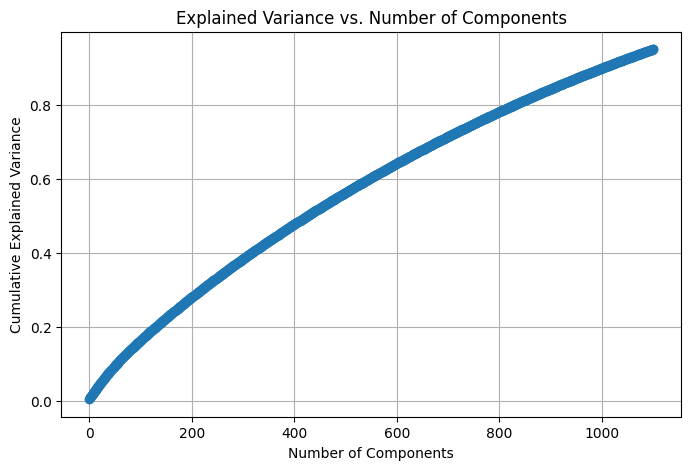

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract activation data (excluding participant ID)
X = train_fmri_df.iloc[:, 1:].values  # Shape (n_samples, 19900)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X)  # Shape: (n_samples, reduced_dim)

# Print number of components selected
print(f"Reduced to {X_pca.shape[1]} principal components")

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

In [3]:
# Based on: https://stackoverflow.com/a/56722874/11620221
# Number of components
num_components = pca.components_.shape[0]

# Get the index of the most important feature 
# on EACH component i.e. largest absolute value
most_important = [np.abs(pca.components_[i]).argmax() for i in range(num_components)]

initial_feature_names = train_fmri_df.columns[1:]

# get the names
most_important_col_names = [initial_feature_names[most_important[i]] for i in range(num_components)]
most_important_col_names

['26throw_129thcolumn',
 '52throw_53thcolumn',
 '37throw_60thcolumn',
 '30throw_56thcolumn',
 '159throw_177thcolumn',
 '55throw_143thcolumn',
 '30throw_56thcolumn',
 '159throw_177thcolumn',
 '159throw_177thcolumn',
 '3throw_103thcolumn',
 '2throw_108thcolumn',
 '160throw_162thcolumn',
 '159throw_177thcolumn',
 '52throw_160thcolumn',
 '14throw_115thcolumn',
 '97throw_162thcolumn',
 '19throw_122thcolumn',
 '55throw_153thcolumn',
 '3throw_103thcolumn',
 '55throw_143thcolumn',
 '1throw_103thcolumn',
 '1throw_103thcolumn',
 '50throw_157thcolumn',
 '159throw_177thcolumn',
 '52throw_54thcolumn',
 '3throw_102thcolumn',
 '52throw_54thcolumn',
 '55throw_143thcolumn',
 '115throw_117thcolumn',
 '127throw_129thcolumn',
 '6throw_114thcolumn',
 '50throw_54thcolumn',
 '1throw_103thcolumn',
 '162throw_169thcolumn',
 '52throw_54thcolumn',
 '159throw_176thcolumn',
 '50throw_153thcolumn',
 '52throw_54thcolumn',
 '65throw_169thcolumn',
 '55throw_143thcolumn',
 '126throw_157thcolumn',
 '19throw_115thcolumn'

In [4]:
# Merge the dataframes
QUANT_INDICES = [0, 9, *range(11, 18)] # Skip Difficulties_Total
train_merged_df = pd.merge(
    train_fmri_df.loc[:, ["participant_id", *most_important_col_names]],
    train_quant_df.iloc[:, QUANT_INDICES],
    on="participant_id",
)
train_merged_df = pd.merge(train_merged_df, train_solutions_df, on="participant_id")
train_merged_df.to_csv("cleaned/TRAIN_MERGED_PCA.csv", index=False)
train_merged_df.head() # Should be 1113 columns: participant_id + 1101 fMRI + 8 SDQ + 2 Solutions

,participant_id,26throw_129thcolumn,52throw_53thcolumn,37throw_60thcolumn,30throw_56thcolumn,159throw_177thcolumn,55throw_143thcolumn,30throw_56thcolumn,159throw_177thcolumn,159throw_177thcolumn,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,ADHD_Outcome,Sex_F
0,70z8Q2xdTXM3,0.349598,0.065042,0.078589,0.100893,0.097534,-0.002699,0.100893,0.097534,0.097534,...,0,1,4,5,4,4,3,9,1,0
1,WHWymJu6zNZi,0.259638,0.090179,0.097306,0.009235,0.096187,0.106966,0.009235,0.096187,0.096187,...,0,0,0,0,0,0,0,0,1,1
2,4PAQp1M6EyAo,0.303860,0.184451,0.085065,0.058028,0.168140,-0.115081,0.058028,0.168140,0.168140,...,8,4,17,8,9,9,5,8,1,1
3,obEacy4Of68I,0.389321,0.104383,0.009456,0.043865,0.092191,0.025773,0.043865,0.092191,0.092191,...,0,2,4,1,4,3,1,10,1,1
4,s7WzzDcmDOhF,0.266398,-0.038770,0.024310,0.057100,-0.016659,0.072332,0.057100,-0.016659,-0.016659,...,3,3,6,3,3,8,5,6,1,1


# Model Selection

In [23]:
from tensorflow.keras import layers, Input, optimizers, metrics
from tensorflow.keras.models import Model


def create_hypermodel(hp):
    # MRI Input Branch (num_components features)
    mri_input = Input(shape=(num_components,), name="mri_input")
    x1 = mri_input

    # Add multiple dense layers with hyperparameter tuning
    for i in range(hp.Int("num_mri_layers", 1, 4)):
        x1 = layers.Dense(
            units=hp.Int(f"mri_units_{i}", min_value=16, max_value=512, step=32),
            activation="relu",
        )(x1)

    # Questionnaire Input Branch
    survey_input = Input(shape=(len(QUANT_INDICES),), name="survey_input")
    x2 = layers.Dense(len(QUANT_INDICES) * 3, activation="relu")(survey_input)

    # Merge both feature representations
    merged = layers.Concatenate()([x1, x2])

    # Add multiple dense layers with hyperparameter tuning
    for i in range(hp.Int("num_layers", 1, 4)):
        merged = layers.Dense(
            units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=32),
            activation="relu",
        )(merged)

    # Add a final Dense layer with two units and
    # sigmoid activation for binary classification
    # (1 = ADHD, 0 = No ADHD / 1 = Female, 0 = Male)
    output = layers.Dense(2, activation="sigmoid")(merged)

    # Compile the model with:
    # - binary cross-entropy loss
    # - SGD optimizer
    # - accuracy metric
    model = Model(inputs=[mri_input, survey_input], outputs=output)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.legacy.SGD(learning_rate=0.1),
        metrics=[
            metrics.AUC(name="auc"),
            metrics.F1Score(name="f1_score", average="macro"),
        ],
    )

    return model

# Model Training & Evaluation

In [24]:
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import KFold

MAX_EPOCHS = 50


def model_eval(X_mri, X_SDQ_scaled, targets):
    # Initialize the BayesianOptimization tuner
    # for hyperparameter search based on Area Under Curve
    tuner = kt.BayesianOptimization(
        create_hypermodel,
        objective=kt.Objective("val_f1_score", direction="max"),
        directory="archive",
        project_name="bayes",
        overwrite=True,
    )

    # K-fold Cross Validation fold counter
    fold_no = 1

    # Define per-fold score containers
    loss_per_fold = []
    f1_per_fold = []

    # Initialize K-fold cross-validation with 3 splits
    kfolder = KFold(n_splits=3, shuffle=True, random_state=42)

    # Go through each fold
    for train, val in kfolder.split(X_SDQ_scaled, targets):
        # Get the training data
        input_vectors = [X_mri[train], X_SDQ_scaled[train]]
        y_train = targets[train]

        # Perform hyperparameter search with Keras Tuner
        tuner.search(
            input_vectors,
            y_train,
            validation_split=0.2,
            verbose=False,
        )

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters()[0]

        # Build the model with the optimal hyperparameters and train it
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(
            input_vectors,
            y_train,
            epochs=MAX_EPOCHS,
            validation_split=0.2,
            verbose=False,
        )

        # Find the best epoch based on validation F1
        val_f1_per_epoch = history.history["val_f1_score"]
        best_epoch = val_f1_per_epoch.index(max(val_f1_per_epoch)) + 1

        # Retrain the model on the best hyperparameters and epoch
        hypermodel = tuner.hypermodel.build(best_hps)
        hypermodel.fit(
            input_vectors,
            y_train,
            epochs=best_epoch,
            validation_split=0.2,
            verbose=False,
        )

        # Vectorize the validation data
        input_vectors_val = [X_mri[val], X_SDQ_scaled[val]]
        y_val = targets[val]

        # Evaluate the model on the validation data
        loss, auc, f1 = hypermodel.evaluate(input_vectors_val, y_val, verbose=False)

        loss_per_fold.append(loss)
        f1_per_fold.append(f1)

        # Increase fold number
        fold_no = fold_no + 1

    # Return the best hyperparameters and their
    # corresponding F1 and loss metrics
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    hp_data = {
        "loss": round(np.mean(loss_per_fold), 3),
        "f1": round(np.mean(f1_per_fold), 3),
        "num_mri_layers": best_hps.values["num_mri_layers"],
        "num_layers": best_hps.values["num_layers"],
    }

    # Capture the best model's structure
    # Track the sequence of layer(s)
    # and their no. of units
    mri_units = []
    units = []

    # Iterate over num_mri_layers
    for i in range(best_hps.values["num_mri_layers"]):
        try:
            # Track no. of mri layers and units
            if best_hps.values[f"mri_units_{i}"]:
                num_mri_units = best_hps.values[f"mri_units_{i}"]

                # Save the number of units per
                # layer in the correct sequence
                mri_units.append(str(num_mri_units))

        except:
            pass

    # Iterate over num_layers
    for i in range(best_hps.values["num_layers"]):
        try:
            # Track the no. of layers and units
            # after the merge
            if best_hps.values[f"units_{i}"]:
                num_units = best_hps.values[f"units_{i}"]

                # Save the number of units per
                # layer in the correct sequence
                units.append(str(num_units))

        except:
            pass

    # Store in hp_data for return
    hp_data["mri_units"] = mri_units
    hp_data["units"] = units

    return hp_data

In [25]:
def find_best_model(tries, X_mri, X_SDQ_scaled, y_train):
    # Track metric & hyperparameter
    # information about the neural networks
    data = []

    for _ in range(tries):
        # Find and save the best neural network structure
        data.append(model_eval(X_mri, X_SDQ_scaled, y_train))

    # Print a table summarizing the neural networks' structures
    print("Loss\t", "F1\t", "Hidden MRI Layers\t", "Hidden Layers\t")

    max_f1_index = -1
    max_f1 = 0

    for i in range(len(data)):
        hp_data = data[i]

        print(
            f"{hp_data['loss']}\t",
            f"{hp_data['f1']}\t",
            f"{' → '.join(hp_data['mri_units'])}\t",
            f"{' → '.join(hp_data['units'])}\t",
        )

        if (hp_data["f1"] > max_f1):
            max_f1 = hp_data["f1"]
            max_f1_index = i

    return data[max_f1_index]

In [29]:
# Try to find the best neural network structure, 7 times
X = train_merged_df.iloc[:, 1:-2].values  # 26throw_129thcolumn ... SDQ_Prosocial
y = train_merged_df.iloc[:, -2:].values.astype("float32")  # ADHD_Outcome	Sex_F

X_SDQ_unscaled = X[:, num_components - 1 :]
X_mri = X[:, :num_components]

best_model_data = find_best_model(
    7, X_mri.copy(), X_SDQ_unscaled.copy(), y
)

Loss	 F1	 Hidden MRI Layers	 Hidden Layers	
0.593	 0.606	 208 → 432 → 208 → 208	 432	
0.579	 0.557	 432 → 336 → 16 → 304	 496 → 304	
0.553	 0.599	 432 → 240 → 80 → 240	 304 → 176	
0.598	 0.593	 400 → 272 → 432	 400	
0.552	 0.585	 496 → 112 → 80 → 16	 176	
0.55	 0.597	 400 → 80 → 336 → 16	 272 → 112	
0.558	 0.597	 48 → 400 → 272	 208	


# Predicting Labels and Performance Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras import callbacks


def create_model(num_mri_layers, num_layers):
    # MRI Input Branch (num_components features)
    mri_input = Input(shape=(num_components,), name="mri_input")
    x1 = mri_input

    # Add multiple dense layers with hyperparameter tuning
    for i in range(len(num_mri_layers)):
        x1 = layers.Dense(
            units=int(num_mri_layers[i]),
            activation="relu",
        )(x1)

    # Questionnaire Input Branch
    survey_input = Input(shape=(len(QUANT_INDICES),), name="survey_input")
    x2 = layers.Dense(len(QUANT_INDICES) * 3, activation="relu")(survey_input)

    # Merge both feature representations
    merged = layers.Concatenate()([x1, x2])

    # Add multiple dense layers with hyperparameter tuning
    for i in range(len(num_layers)):
        merged = layers.Dense(
            units=int(num_layers[i]),
            activation="relu",
        )(merged)

    # Add a final Dense layer with two units and
    # sigmoid activation for binary classification
    # (1 = ADHD, 0 = No ADHD / 1 = Female, 0 = Male)
    output_adhd = layers.Dense(1, activation="sigmoid", name="adhd_output")(merged)
    output_sex = layers.Dense(1, activation="sigmoid", name="sex_output")(merged)

    # Compile the model with:
    # - binary cross-entropy loss
    # - SGD optimizer
    # - accuracy metric
    model = Model(inputs=[mri_input, survey_input], outputs=[output_adhd, output_sex])
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.legacy.SGD(learning_rate=0.1),
        metrics=[
            metrics.AUC(name="auc"),
            metrics.F1Score(name="f1_score", average="macro"),
        ],
    )

    return model


# Re-create the model from the best hyperparameters
best_model = create_model(best_model_data["mri_units"], best_model_data["units"])

# Train-test split on our training dataset (1213 rows)
X_mri_train, X_mri_test, X_SDQ_train, X_SDQ_test, y_train, y_test = train_test_split(
    X_mri, X_SDQ_unscaled, y, test_size=0.2, random_state=42
)

# Train the model
best_model.fit(
    [X_mri_train, X_SDQ_train],
    y_train,
    callbacks=[callbacks.EarlyStopping(monitor="f1_score", patience=2)],
    verbose=False,
)

# Predict classes
y_pred = best_model.predict([X_mri_test, X_SDQ_test])
y_pred

8/8 [==============================] - 0s 939us/step


array([[0.96708125, 0.359992  ],
       [0.98134416, 0.41496214],
       [0.9834792 , 0.54332906],
       [0.7575003 , 0.5381147 ],
       [0.8582862 , 0.403673  ],
       [0.3973847 , 0.44424713],
       [0.49955356, 0.4988873 ],
       [0.74625385, 0.4753266 ],
       [0.8865192 , 0.5562607 ],
       [0.25894895, 0.4991648 ],
       [0.9861185 , 0.5504032 ],
       [0.8024586 , 0.52629983],
       [0.9722102 , 0.39331767],
       [0.9368247 , 0.5741009 ],
       [0.84930795, 0.5379119 ],
       [0.86936814, 0.5580633 ],
       [0.9398354 , 0.56210625],
       [0.5540186 , 0.5385212 ],
       [0.9585545 , 0.49472684],
       [0.58820593, 0.40802896],
       [0.94061875, 0.49270153],
       [0.97330344, 0.57069755],
       [0.44486937, 0.46507224],
       [0.9582375 , 0.32091022],
       [0.3072899 , 0.5079636 ],
       [0.79590046, 0.5136964 ],
       [0.45489386, 0.5336107 ],
       [0.92518634, 0.48855847],
       [0.50217104, 0.5709745 ],
       [0.4467807 , 0.4268773 ],
       [0.

In [48]:
# Evaluate the best model on the test set
converted_y_pred = (np.array(y_pred) >= 0.5).astype(int)
nn_roc_auc = roc_auc_score(y_test, y_pred)

# Convert the probabilities to binary
nn_accuracy = accuracy_score(y_test, converted_y_pred)

# Report the F-1 Score on the test set (note: The datathon uses F1-Score)
print("F1-Score:", f1_score(y_test, converted_y_pred, average='macro'))

# Report the ROC-AUC score on the test set
print("ROC-AUC Score on Test Set:", nn_roc_auc)

# Report the accuracy on the test set
print("Accuracy Score on Test Set:", nn_accuracy)



F1-Score: 0.6836320471298563
ROC-AUC Score on Test Set: 0.7340834384436036
Accuracy Score on Test Set: 0.5102880658436214
